In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!apt-get update
!apt-get install cmake
!pip install --upgrade setuptools
!pip install ez_setup
!pip install gym[atari]
!pip install git+https://github.com/tensorflow/docs

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


  Cloning https://github.com/tensorflow/docs to c:\users\vedant\appdata\local\temp\pip-req-build-27d0jrfz
  Resolved https://github.com/tensorflow/docs to commit c0c4ab3446e236893dfab72b7296f635ddbafccf
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\Vedant\AppData\Local\Temp\pip-req-build-27d0jrfz'


In [2]:
!pip install tensorflow-gpu

In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import datetime
import gym
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [8]:
class ActorCriticModel(tf.keras.Model):
    """
    Defining policy and value networkss
    """
    def __init__(self, action_size, n_hidden1=8, n_hidden2=4):
        super(ActorCriticModel, self).__init__()

        #Hidden Layer 1
        self.fc1 = tf.keras.layers.Dense(n_hidden1, activation='relu')
        #Hidden Layer 2
        self.fc2 = tf.keras.layers.Dense(n_hidden2, activation='relu')
        
        #Output Layer for policy
        self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
        #Output Layer for state-value
        self.v_out = tf.keras.layers.Dense(1)

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        layer1 = self.fc1(state)
        layer2 = self.fc2(layer1)

        pi = self.pi_out(layer2)
        v = self.v_out(layer2)

        return pi, v

### Agent Class
###**Task 2a:** Write code to compute $\delta_t$ inside the Agent.learn() function



In [9]:
class Agent:
    """
    Agent class
    """
    def __init__(self, action_size, lr=5e-5, gamma=0.99):
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        # np.random.seed(seed)
    
    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi,_ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0,action]) * delta

    def critic_loss(self,delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    @tf.function
    def learn(self, state, action, reward, next_state, done):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
        gradient of the total loss
        """
        with tf.GradientTape(persistent=True) as tape:
            pi, V_s = self.ac_model(state)
            _, V_s_next = self.ac_model(next_state)

            V_s = tf.squeeze(V_s)
            V_s_next = tf.squeeze(V_s_next)

            #### TO DO: Write the equation for delta (TD error)
            ## Write code below
            delta = reward + self.gamma * V_s_next - V_s
            
            V_s_next = tf.stop_gradient(V_s_next)

            loss_a = self.actor_loss(action, pi, delta)
            loss_c =self.critic_loss(delta)
            loss_total = loss_a + loss_c

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))

### Train the Network

In [10]:
# env = gym.make('CartPole-v1')
from tqdm.notebook import tqdm_notebook as tqdm
env = gym.make('MountainCar-v0')

# print env info
print("Action Space: ", env.action_space)
print("Action Size: ", env.action_space.n)
print(env.reset().reshape(1,-1))


Action Space:  Discrete(3)
Action Size:  3
[[-0.46781585  0.        ]]


In [11]:

#Initializing Agent
agent = Agent(lr = 1e-6, action_size=env.action_space.n)
#Number of episodes
episodes = 10000
tf.compat.v1.reset_default_graph()

reward_list = []
average_reward_list = []
begin_time = datetime.datetime.now()

for ep in tqdm(range(1, episodes + 1)):
    state = env.reset().reshape(1,-1)
    done = False
    ep_rew = 0
    while not done:
        action = agent.sample_action(state) ##Sample Action
        next_state, reward, done, info = env.step(action) ##Take action
        next_state = next_state.reshape(1,-1)
        ep_rew += reward  ##Updating episode reward
        agent.learn(state, action, reward, next_state, done) ##Update Parameters
        state = next_state ##Updating State
    reward_list.append(ep_rew)
    if(len(reward_list) >= 20):
      avg_100 =  np.mean(reward_list[-20:])
      average_reward_list.append(avg_100)
    else:
      avg = np.mean(reward_list)
      average_reward_list.append(avg)

    if ep % 1 == 0:
        avg_rew = np.mean(reward_list[-1:])
        print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

    if ep % 20:
        avg_100 =  np.mean(reward_list[-20:])
        if avg_100 > -50.0:
            print('Stopped at Episode ',ep-20)
            # break

time_taken = datetime.datetime.now() - begin_time
print(time_taken)

  0%|          | 0/10000 [00:00<?, ?it/s]

Episode  1 Reward -200.000000 Average Reward -200.000000
Episode  2 Reward -200.000000 Average Reward -200.000000
Episode  3 Reward -200.000000 Average Reward -200.000000
Episode  4 Reward -200.000000 Average Reward -200.000000
Episode  5 Reward -200.000000 Average Reward -200.000000
Episode  6 Reward -200.000000 Average Reward -200.000000
Episode  7 Reward -200.000000 Average Reward -200.000000
Episode  8 Reward -200.000000 Average Reward -200.000000
Episode  9 Reward -200.000000 Average Reward -200.000000
Episode  10 Reward -200.000000 Average Reward -200.000000
Episode  11 Reward -200.000000 Average Reward -200.000000
Episode  12 Reward -200.000000 Average Reward -200.000000
Episode  13 Reward -200.000000 Average Reward -200.000000
Episode  14 Reward -200.000000 Average Reward -200.000000
Episode  15 Reward -200.000000 Average Reward -200.000000
Episode  16 Reward -200.000000 Average Reward -200.000000
Episode  17 Reward -200.000000 Average Reward -200.000000
Episode  18 Reward -200

KeyboardInterrupt: 

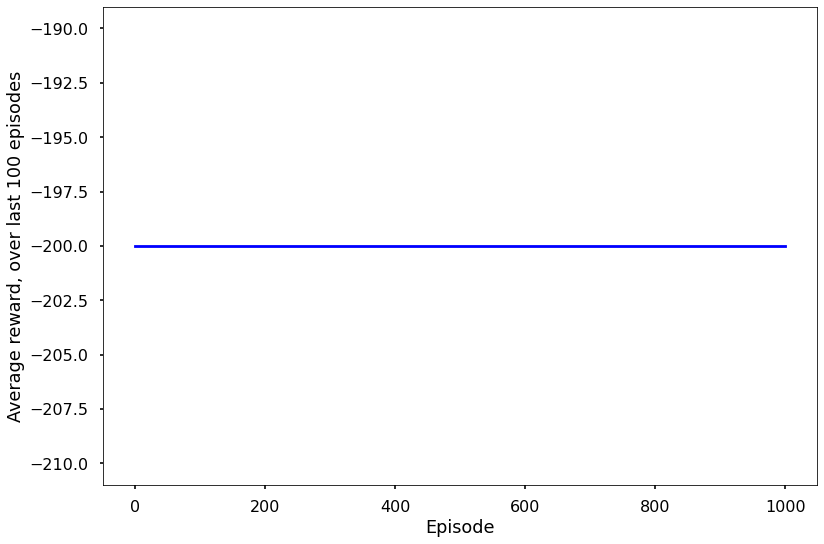

In [6]:
### Plot of total reward vs episode
## Write Code Below

plt.style.use('seaborn-poster')
# plt.figure(figsize = (10,8))
plt.xlabel('Episode')
plt.ylabel('Average reward, over last 100 episodes')
plt.plot(range(len(average_reward_list)),average_reward_list, 'b')
plt.show()


In [ ]:
# Render an episode and save as a GIF file

display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))
    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(env, agent.ac_model, 200)
image_file = 'acrobot-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


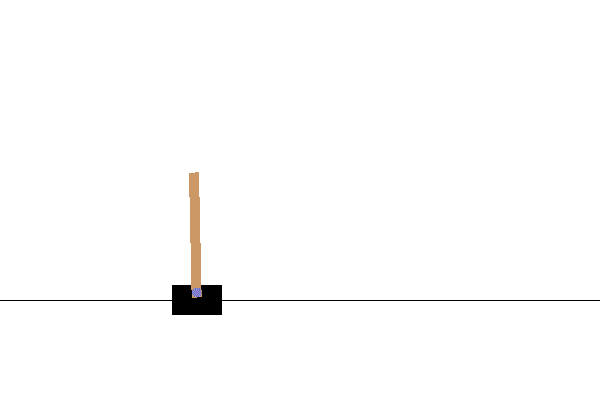

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)